In [5]:
from __future__ import print_function, division
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from stl import mesh

%matplotlib notebook
#%matplotlib widget

## Define functions
### Triangle intersection

source: https://en.wikipedia.org/wiki/M%C3%B6ller%E2%80%93Trumbore_intersection_algorithm

In [25]:
def RayIntersectsTriangle(RayOrigin, RayVector, Triangle):
    """
    Möller-Trumbore ray-triangle intersection algorithm
    
    https://en.wikipedia.org/wiki/M%C3%B6ller%E2%80%93Trumbore_intersection_algorithm
    """
    Vertex0 = Triangle[0]
    Vertex1 = Triangle[1]
    Vertex2 = Triangle[2]
    Epsilon = 0.0000001
    Edge1 = Vertex1 - Vertex0
    Edge2 = Vertex2 - Vertex0
    h = np.cross(RayVector, Edge2)
    a = Edge1.dot(h)
    if a>-Epsilon and a<Epsilon:
        # This ray is parallel to this triangle.
        return False, None
    f = 1.0 / a
    s = RayOrigin - Vertex0
    u = f * s.dot(h)
    if u < 0.0 or u > 1.0:
        return False, None
    q = np.cross(s, Edge1)
    v = f * RayVector.dot(q)
    if v < 0.0 or u + v > 1.0:
        return False, None
    # At this stage we can compute t to find out where the intersection point is on the line.
    t = f * Edge2.dot(q)
    if t > Epsilon:
        # ray intersection
        outIntersectionPoint = RayOrigin + RayVector * t
        return True, outIntersectionPoint
    else:
        # This means that there is a line intersection but not a ray intersection.
        return False, None

### cast a ray from an origin vector in a certain direction and intesect with the mesh

In [16]:
def cast_ray(ray_origin, ray_dir, cavity):
    ps = [] # for intersect positions
    ixs = [] # indices of triangle in mesh for later use
    distances = [] # distances between ray_origin and intersection point
    for i, tri in enumerate(cavity.vectors):
        # perform intersection for all triangles in stl mesh
        succ, p = RayIntersectsTriangle(ray_origin, ray_dir, tri)
        if succ:
            if np.dot(ray_dir, cavity.normals[i])<0:
                # if incident ray and normals are in oposite directions
                # otherwise it's the outside of the cavity?
                ps.append(p)
                ixs.append(i)
                d = p-ray_origin
                distances.append(np.sqrt(d.dot(d)))
    return ixs, ps, distances

### calculate reflected ray using the normal of the associated triangle

In [13]:
def calc_reflected_ray(normal, ray_dir):
    # normalize normal vector
    nn = normal/np.sqrt(normal.dot(normal))
    # return new direction
    return ray_dir - 2* np.dot(ray_dir, nn)*nn

## Read in .stl model

In [9]:
cavity = mesh.Mesh.from_file('./cavity_idea.stl')
print(cavity.vectors.shape[0], 'triangles in mesh')

3288 triangles in mesh


## Plot .stl and all triangles
this is still slow, converting all triangles into a collection might make things quicker ...

<IPython.core.display.Javascript object>


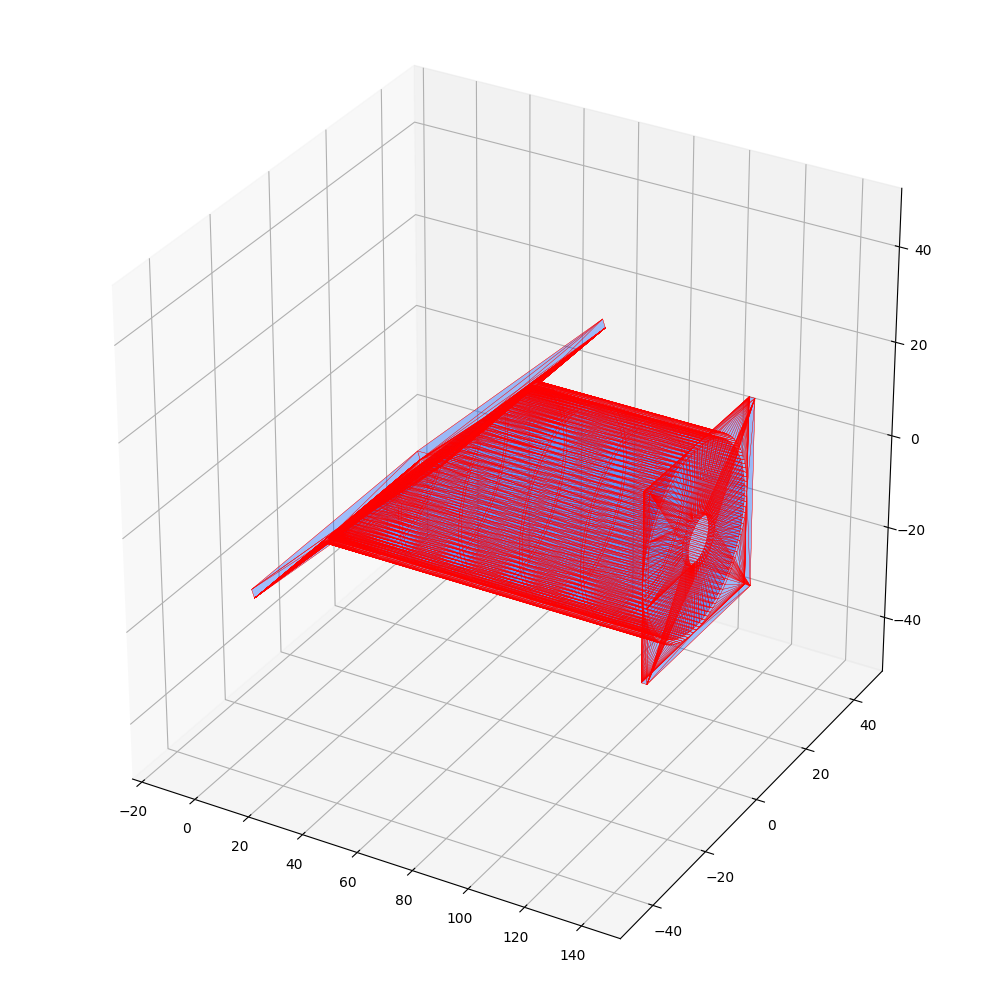

In [11]:
figure = plt.figure(figsize=(10,10))
axes = mplot3d.Axes3D(figure)
collection = mplot3d.art3d.Poly3DCollection(cavity.vectors)
collection.set_facecolor('#0055FF33')
axes.set_xlim(-20,150)
axes.set_ylim(-50,50)
axes.set_zlim(-50,50)
axes.add_collection3d(collection)

for i in range(cavity.vectors.shape[0]):
    tri = cavity.vectors[i]
    xs = [tri[0][0], tri[1][0], tri[2][0], tri[0][0]]
    ys = [tri[0][1], tri[1][1], tri[2][1], tri[0][1]]
    zs = [tri[0][2], tri[1][2], tri[2][2], tri[0][2]]
    axes.plot3D(xs, ys, zs, 'r-', linewidth=0.2)

scale = cavity.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)


## Define origin of ray and calculate reflections

In [27]:
# list, to be filled with new intersection points
ray_origins = [np.array([170.0, 1.3, 1.5])]
# same for directions
ray_dirs = [np.array([-1,0,0])]
# and hit triangles (only for plotting)
tris = []

# do 'depth' number of reflections
depth = 10

for i in range(depth):
    ixs, ps, dists = cast_ray(ray_origins[i], ray_dirs[i], cavity)
    # take intersection with smallest distance to ray_origin
    ii = dists.index(np.min(dists))
    ray_origins.append(ps[ii])
    ray_dirs.append(calc_reflected_ray(cavity.normals[ixs[ii]], ray_dirs[i]))
    tris.append(cavity.vectors[ixs[ii]])
    print(i, ixs, ps, dists)

0 [580] [array([37.23909396,  1.3       ,  1.5       ])] [132.7609060417161]
1 [3046] [array([ 25.4297771 ,   1.3       , -18.95429489])] [23.618597417201638]
2 [557] [array([19.50912848,  0.43029972, -8.73640006])] [11.841276680796323]
3 [3031] [array([ 25.40655115,  -0.4406983 , -18.98805542])] [11.858948919762733]
4 [580] [array([37.13431794, -1.59511509,  1.4395076 ])] [23.583013439240236]
5 [165] [array([130.        ,  -6.14647133,   1.2137589 ])] [92.97742043841343]
6 [579] [array([ 36.34899412, -10.73631637,   0.98610115])] [93.76368917883558]
7 [2967] [array([ 27.0608874 , -11.6429198 , -15.01140271])] [18.520555766258123]
8 [555] [array([18.010042  ,  3.00392729, -9.60189778])] [18.047456208184414]
9 [2866] [array([ 18.09801748,  11.0905701 , -15.42278127])] [9.96414653948243]


### Plot results

<IPython.core.display.Javascript object>


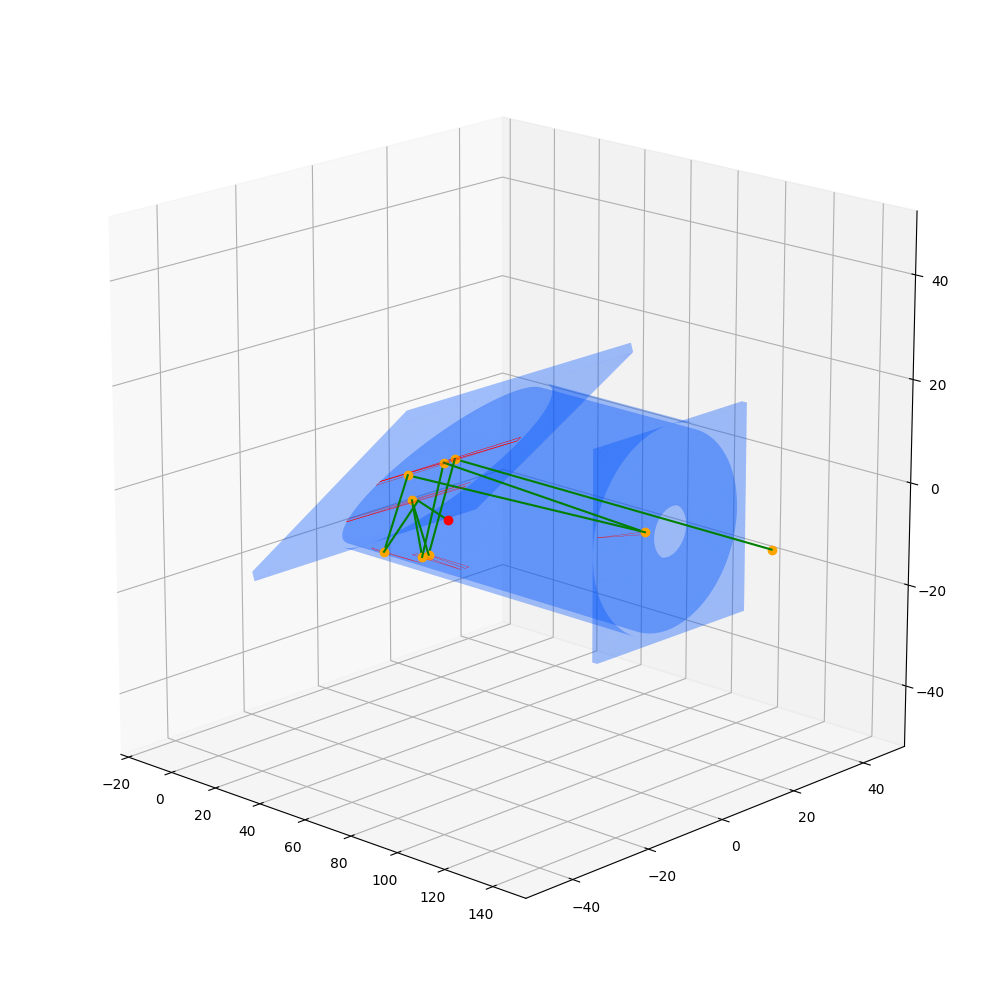

/home/matthias/py2/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


In [28]:

figure = plt.figure(figsize=(10,10))
axes = mplot3d.Axes3D(figure)
collection = mplot3d.art3d.Poly3DCollection(cavity.vectors)
collection.set_facecolor('#0055FF33')
axes.set_xlim(-20,150)
axes.set_ylim(-50,50)
axes.set_zlim(-50,50)
axes.add_collection3d(collection)

for i in range(depth-1):
    tri = tris[i]
    xs = [tri[0][0], tri[1][0], tri[2][0], tri[0][0]]
    ys = [tri[0][1], tri[1][1], tri[2][1], tri[0][1]]
    zs = [tri[0][2], tri[1][2], tri[2][2], tri[0][2]]
    axes.plot3D(xs, ys, zs, 'r-', linewidth=0.2)
    p = ray_origins[i]
    axes.plot3D([p[0]], [p[1]], [p[2]], 'o', color='orange')
    axes.plot3D([ray_origins[i][0], ray_origins[i+1][0]], [ray_origins[i][1], ray_origins[i+1][1]], [ray_origins[i][2], ray_origins[i+1][2]], 'g-')

axes.plot3D([ray_origins[-2][0], ray_origins[-1][0]], [ray_origins[-2][1], ray_origins[-1][1]], [ray_origins[-2][2], ray_origins[-1][2]], 'g-')
axes.plot3D([ray_origins[-1][0]], [ray_origins[-1][1]], [ray_origins[-1][2]], 'ro')

scale = cavity.points.flatten(-1)
axes.auto_scale_xyz(scale, scale, scale)